# 0. Create a random tree topology

In [42]:
# change working directory
import os
os.chdir('/Users/khalilouardini/Desktop/projects/scVI/scvi')

#standard imports
import matplotlib.pyplot as plt
from ete3 import Tree
import networkx as nx
import numpy as np
from matplotlib import rcParams
from utils.baselines import avg_weighted_baseline, scvi_baseline, scvi_baseline_z, cascvi_baseline_z
from utils.metrics import ks_pvalue, accuracy_imputation, correlations
import copy

%matplotlib inline 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
t = Tree()
t.populate(60)

In [26]:
for i, n in enumerate(t.traverse()):
    n.dist = 1.0
    n.add_features(index=i)
    if not n.name:
        n.name = str(i)

In [27]:
#Copy tree

augmented_t = copy.deepcopy(t)

print(t)


               /-aaaaaaaaaz
            /-|
           |  |   /-aaaaaaaabb
           |   \-|
           |      \-aaaaaaaabc
         /-|
        |  |      /-aaaaaaaabd
        |  |   /-|
        |  |  |   \-aaaaaaaabe
        |   \-|
        |     |   /-aaaaaaaabf
      /-|      \-|
     |  |         \-aaaaaaaabg
     |  |
     |  |      /-aaaaaaaabh
     |  |   /-|
     |  |  |   \-aaaaaaaabi
     |   \-|
     |     |   /-aaaaaaaabj
     |      \-|
     |        |   /-aaaaaaaabk
     |         \-|
     |           |   /-aaaaaaaabl
     |            \-|
     |               \-aaaaaaaabm
     |
     |         /-aaaaaaaabn
     |      /-|
     |     |   \-aaaaaaaabo
   /-|     |
  |  |     |      /-aaaaaaaabp
  |  |   /-|   /-|
  |  |  |  |  |  |   /-aaaaaaaabq
  |  |  |  |  |   \-|
  |  |  |  |  |     |   /-aaaaaaaabr
  |  |  |  |  |      \-|
  |  |  |   \-|        |   /-aaaaaaaabs
  |  |  |     |         \-|
  |  |  |     |            \-aaaaaaaabt
  |  |  |     |
  |  |  |     |   /-

Tree Augmentation

In [28]:
N = 20
for n in augmented_t.get_leaves():
    for i in range(1, N):
        n.up.add_child(name=n.name + '-' + str(i),
                    dist=1.0
                    )

In [29]:
print(augmented_t)


               /-aaaaaaaaaz
              |
              |   /-aaaaaaaabb
              |  |
              |  |--aaaaaaaabc
              |  |
              |  |--aaaaaaaabb-1
              |  |
              |  |--aaaaaaaabb-2
              |  |
              |  |--aaaaaaaabb-3
              |  |
              |  |--aaaaaaaabb-4
              |  |
              |  |--aaaaaaaabb-5
              |  |
              |  |--aaaaaaaabb-6
              |  |
              |  |--aaaaaaaabb-7
              |  |
              |  |--aaaaaaaabb-8
              |  |
              |  |--aaaaaaaabb-9
              |  |
              |  |--aaaaaaaabb-10
              |  |
              |  |--aaaaaaaabb-11
              |  |
              |  |--aaaaaaaabb-12
              |  |
              |  |--aaaaaaaabb-13
              |  |
              |  |--aaaaaaaabb-14
              |  |
              |  |--aaaaaaaabb-15
              |  |
              |  |--aaaaaaaabb-16
              |  |
              | 

In [30]:
for i, n in enumerate(augmented_t.traverse()):
    n.add_features(index=i)

# 1. Simulations

$\Sigma$ the covariance matrix is derived from the Cassioepia reconstructed phylogenetic tree. A gaussian latent vector can be sampled

$$
z \sim \mathcal{N}(0, \Sigma)
$$

Here we assume that the canonical parameter $\theta$ is given by a linear mapping of the latent vector such that:
$\forall$ i

$$
\theta_i = W z_i + \beta  
$$

and the mean of the poisson distribution if given by the link function

$$
\mu_i = exp (\theta_i)
$$

The gene expression level is drawn from the poisson distribution:

$$
x_i|z_i ~ Poisson(\mu_i)
$$

In [31]:
from dataset.poisson_glm import Poisson_GLM
from utils.data_util import get_leaves, get_internal
from utils.plots_util import plot_histograms, plot_embedding, plot_density, plot_scatter_mean
from utils.plots_util import plot_ecdf_ks, plot_elbo, plot_losses, plot_scatter_samples

from anndata import AnnData
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 

In [32]:
d = 5
g = 100
vis = False
leaves_only = False
var = 1.0

glm = Poisson_GLM(t, g, d, vis, leaves_only, var)
glm.simulate_latent()

In [33]:
glm.simulate_ge()

# Quality Control (i.e Gene Filtering)
#glm.gene_qc()

***Seprate datasets into leaves and internal nodes***

In [34]:
# Making sure that there are no Zeros at the leaves
#for i, n in enumerate(t.traverse()):
#    if n.is_leaf() and glm.X[i][0] == 0:
#        glm.X[i][0] = 1

In [35]:
#FIXED training set
leaves_X, leaves_idx, mu = get_leaves(glm.X, glm.mu, t)
leaves_z, _, _ = get_leaves(glm.z, glm.mu, t)

# internal nodes data (for imputation)
internal_X, internal_idx, internal_mu = get_internal(glm.X, glm.mu, t)

leaves_X.shape, mu.shape, internal_X.shape, internal_mu.shape, leaves_z.shape

((60, 100), (60, 100), (59, 100), (59, 100), (60, 5))

#### UMAP / t-SNE

Dataset and model imports

In [36]:
# Data
from dataset.anndataset import AnnDatasetFromAnnData
from anndata import AnnData
from dataset.tree import TreeDataset, GeneExpressionDataset

# Models
from models import *;
import scanpy as sc
from inference.tree_inference import TreeTrainer
from inference.inference import UnsupervisedTrainer
from inference import posterior
from models.treevae import TreeVAE

***Simulate multiple times at the leaves***

In [37]:
n_leaves_X = glm.generate_new_ge(n_samples=20, leaves_idx=leaves_idx)
len(n_leaves_X)

20

Create Gene expression dataset (with 3-dimensional array)

In [38]:
scvi_dataset = GeneExpressionDataset()

# (n_samples, n_cells, n_genes)
#cell_names = np.array([[n.name for n in list(t.get_leaves())] * len(n_leaves_X)]).flatten()
cell_names = [n.name for n in list(augmented_t.get_leaves())]
#scvi_dataset.populate_from_per_batch_list(Xs=n_leaves_X,
#                                         gene_names=[str(i) for i in range(glm.X.shape[1])]
#                                        )

# (n_cells, n_genes)
#cell_names = [n.name for n in list(t.get_leaves())]
scvi_dataset.populate_from_data(X=np.vstack(n_leaves_X),
                               gene_names=[str(i) for i in range(glm.X.shape[1])])

scvi_dataset.initialize_cell_attribute('barcodes', cell_names)
scvi_dataset

[2021-03-22 12:03:25,907] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-03-22 12:03:25,907] INFO - scvi.dataset.dataset | Remapping labels to [0,N]


GeneExpressionDataset object with n_cells x nb_genes = 1200 x 100
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'batch_indices', 'local_means', 'barcodes', 'local_vars', 'labels'
    cell_categorical_attribute_names: 'batch_indices', 'labels'

***Dimensionality reduction of (t-SNE, UMAP) of latent space***

In [40]:
sizes = []
for i, n in enumerate(t.traverse()):
    if n.is_leaf():
        sizes.append(50)
    else:
        sizes.append(300)

//anaconda3/envs/berkeley/lib/python3.7/site-packages/matplotlib/collections.py:1039: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


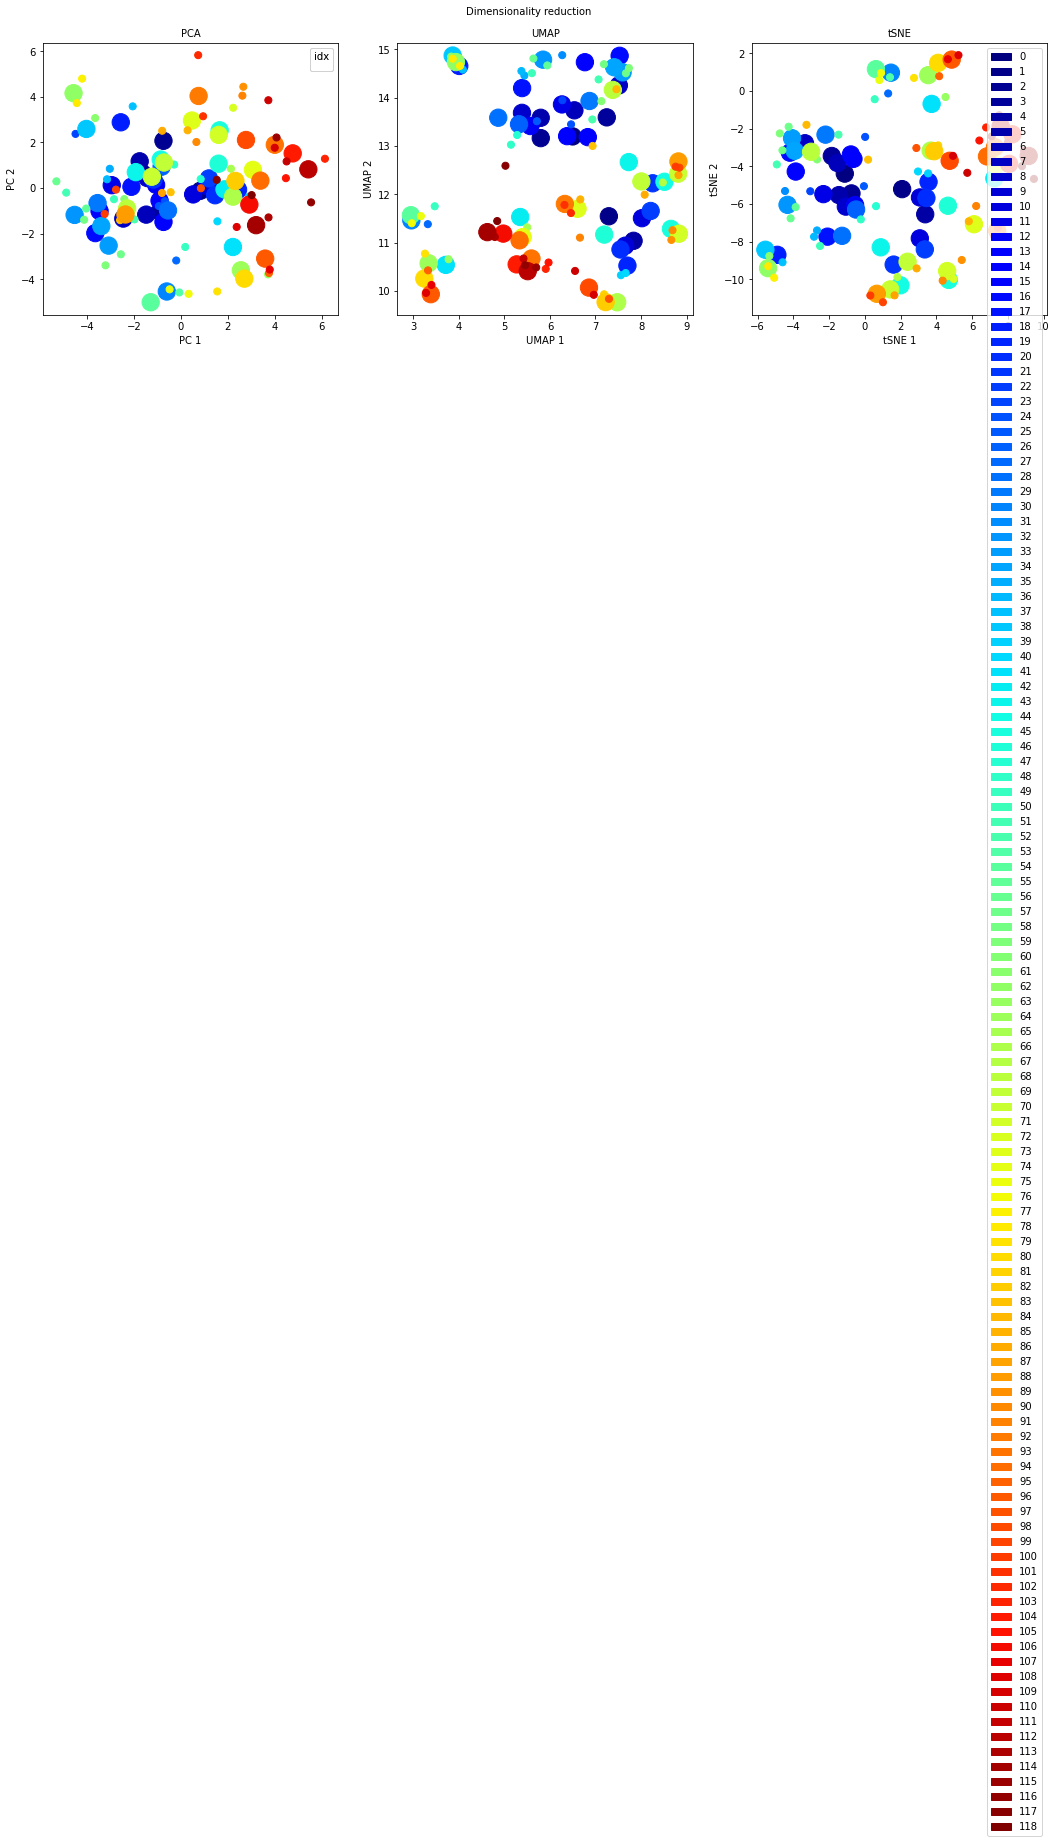

In [43]:
plot_embedding(X=glm.z, 
               color_index=list(range(glm.z.shape[0])),
              sizes=sizes
              )

***Dimensionality reduction of input data (t-SNE, UMAP) of input data***

//anaconda3/envs/berkeley/lib/python3.7/site-packages/matplotlib/collections.py:1039: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


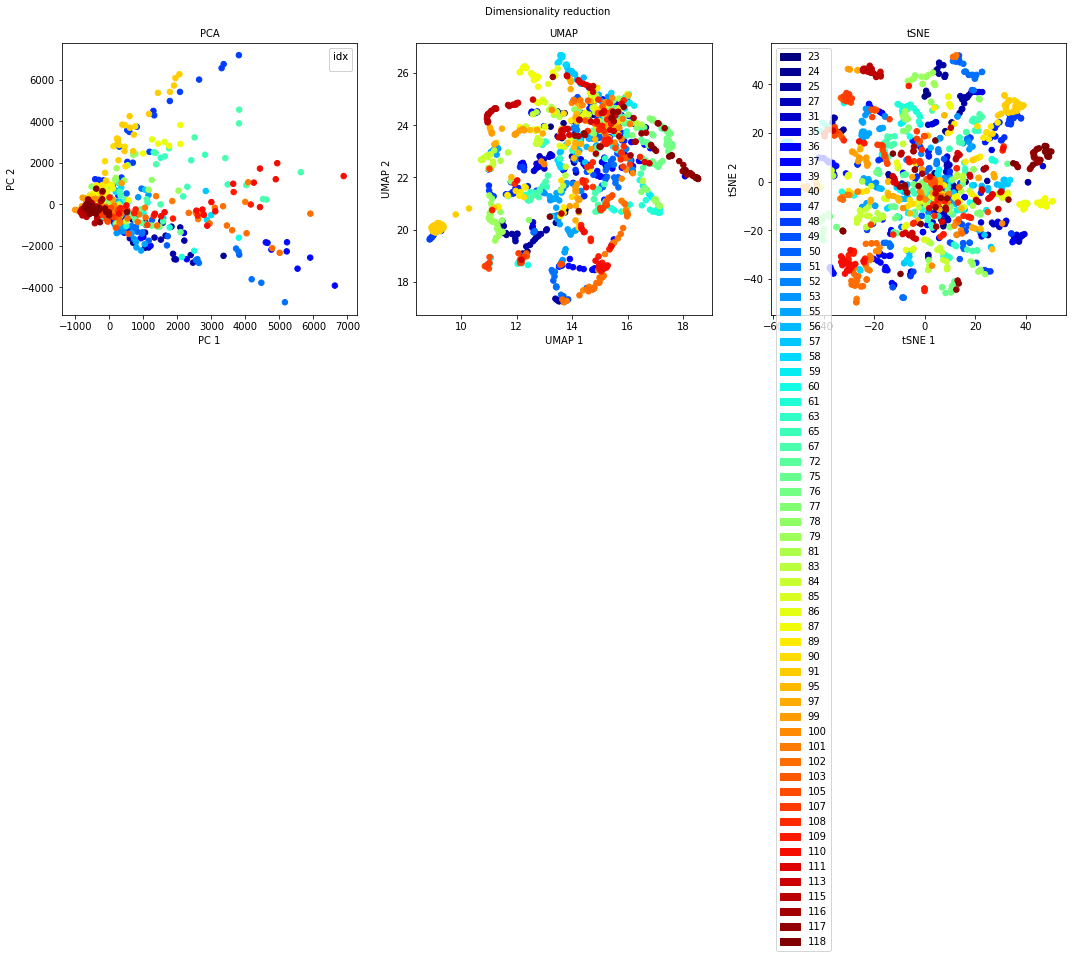

In [44]:
group = np.array([ [int(i)] * len(n_leaves_X) for i in leaves_idx]).flatten()

plot_embedding(X=scvi_dataset.X, 
               color_index=group,
              sizes=[30 for i in range(scvi_dataset.X.shape[0])])

#  2. Fit scVI

training: 100%|██████████| 1500/1500 [00:30<00:00, 49.74it/s]


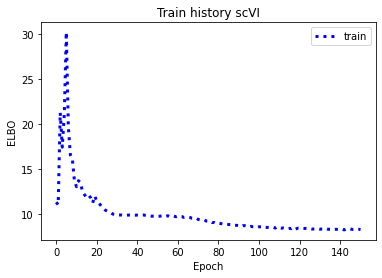

In [45]:
n_epochs = 1500

vae_scvi = VAE(scvi_dataset.nb_genes, n_hidden=32, n_layers=1,
               reconstruction_loss='poisson', n_latent=glm.latent)

trainer_scvi = UnsupervisedTrainer(model=vae_scvi, gene_dataset=scvi_dataset,
                              train_size=1.0, use_cuda=False, frequency=10,
                              n_epochs_kl_warmup=500, batch_size=scvi_dataset._X.shape[0])

# train scVI
trainer_scvi.train(n_epochs=n_epochs, lr=1e-3) 

elbo_train_scvi = trainer_scvi.history["elbo_train_set"]

x = np.linspace(0, 100, (len(elbo_train_scvi)))
plt.plot(np.log(elbo_train_scvi), 
         label="train", color='blue',
         linestyle=':',
         linewidth=3)

plt.xlabel('Epoch')
plt.ylabel("ELBO")
plt.legend()
plt.title("Train history scVI")
plt.show()

In [46]:
scvi_posterior = trainer_scvi.create_posterior(model=vae_scvi,
                                              gene_dataset=scvi_dataset,
                                              )
                                              
scvi_latent = scvi_posterior.get_latent()[0]
scvi_latent.shape

(1200, 5)

Prepare gene expression array for Anndata class

In [47]:
#leaf_index = []
#adata_X = []
#for i in range(n_leaves_X[0].shape[0]):
    #for j in range(len(n_leaves_X)):
        #leaf_index.append(str(leaves_idx[i]))
        #adata_X.append(n_leaves_X[j][i, :])
#adata_X = np.vstack(adata_X)          

***UMAP Embeddings of scVI latent space***

In [48]:
import scanpy as sc

sc.set_figure_params(dpi=100, color_map = 'viridis_r')
sc.settings.verbosity = 1

In [49]:
adata = AnnData(scvi_dataset.X)
adata.layers["counts"] = adata.X.copy() #preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`
adata.obsm["X"] = adata.X
adata.obsm["Z"] = scvi_latent

adata.obs.insert(0, 'barcodes', list(scvi_dataset.barcodes), True)
adata.obs.insert(0, 'leaf_index', np.array([[str(i)] * len(n_leaves_X) for i in leaves_idx]).flatten(), True)

In [50]:
adata.obs.head(5)

,leaf_index,barcodes
0,23,aaaaaaaaaz
1,23,aaaaaaaabb
2,23,aaaaaaaabc
3,23,aaaaaaaabb-1
4,23,aaaaaaaabb-2


In [51]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="Z")
sc.tl.umap(adata,
           min_dist=0.2)

***scVI latent space***

... storing 'leaf_index' as categorical


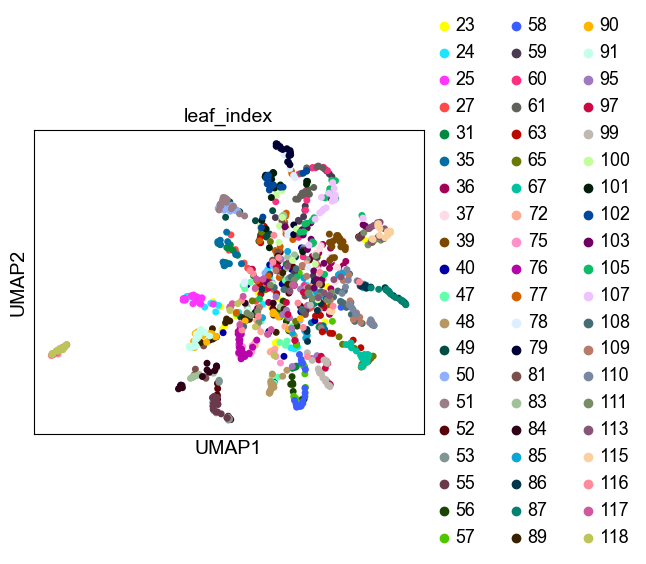

In [52]:
rcParams['figure.figsize'] = 5, 4

sc.pl.umap(
    adata,
    color='leaf_index',
    frameon=True,
    s=100
)

//anaconda3/envs/berkeley/lib/python3.7/site-packages/matplotlib/collections.py:1039: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


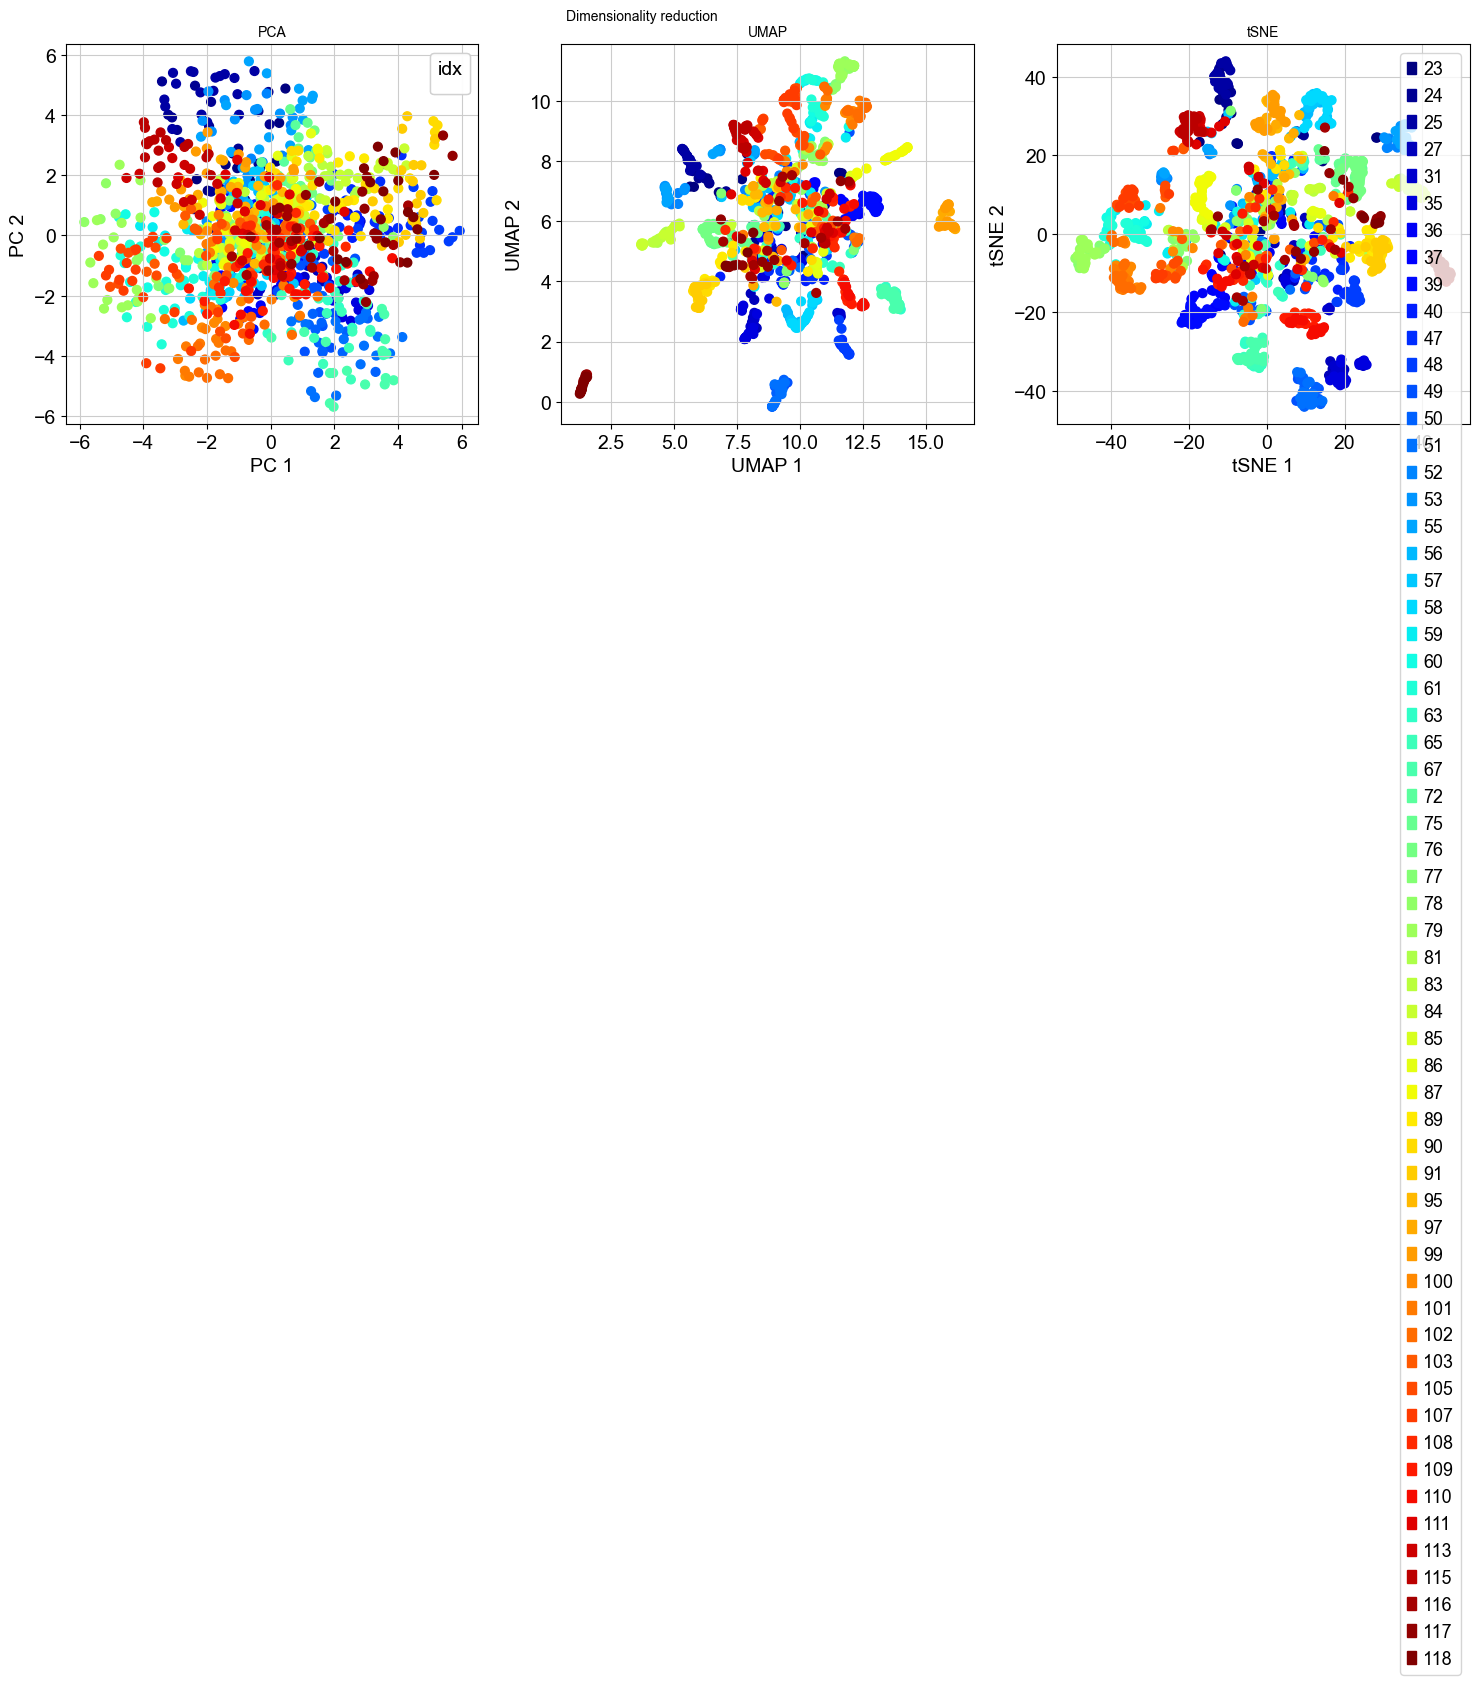

In [53]:
group = np.array([[int(i)] * len(n_leaves_X) for i in leaves_idx]).flatten()
plot_embedding(X=scvi_latent, 
               color_index=group,
               sizes=[40 for i in range(scvi_latent.shape[0])]
              )

#### Latent space averaging for ancestral node imputation

In [54]:
# scVI baseline 1
N = 1
library_size = 160
imputed_scvi, imputed_scvi_z = scvi_baseline(augmented_t, scvi_posterior, False, True, N)

#scVI baseline 2
imputed_scvi_2 = scvi_baseline_z(tree=augmented_t,
                                 model=vae_scvi,
                                 posterior=scvi_posterior,
                                 weighted=True,
                                 n_samples_z=100,
                                 library_size=library_size
                                )

In [55]:
imputed_scvi_X = []
for n in t.traverse():
    if n.is_leaf():
        imputed_scvi_X.append(glm.X[n.index])
    else:
        imputed_scvi_X.append(imputed_scvi[str(n.index)])
imputed_scvi_X = np.array(imputed_scvi_X)

Create a new matrix with the imputed and the leaves latent vectors.

In [56]:
new_scvi_latent = []
internal_group = []
sizes = []
idx = 0
for i, n in enumerate(augmented_t.traverse()):
    if n.is_leaf():
        new_scvi_latent.append(scvi_latent[idx])
        sizes.append(70)
        idx += 1
    else:
        new_scvi_latent.append(imputed_scvi_z[int(n.name)])
        internal_group.append([int(n.name)]*N)
        for i in range(N):
            sizes.append(300)
new_scvi_latent = np.vstack(new_scvi_latent)

KeyError: 0

Add imputed latent space to the plot

In [ ]:
new_group = list(group) + list(np.array(internal_group).flatten())
new_group.sort()

Add the imputed latent vectors to the embeddings

In [ ]:
plot_embedding(X=new_scvi_latent, 
               color_index=new_group,
               sizes=sizes
              )

# 3. Fit CascVI 

***Anndata***

Introduce a unique barcode for each sample

In [36]:
gene_dataset = GeneExpressionDataset()

# (n_samples, n_cells, n_genes)
cell_names = [n.name for n in augmented_t.get_leaves()]
#gene_dataset.populate_from_per_batch_list(Xs=n_leaves_X,
#                                         gene_names=[str(i) for i in range(glm.X.shape[1])]
#                                         )

#  (n_cells, n_genes)
#cell_names = [n.name for n in list(t.get_leaves())]
gene_dataset.populate_from_data(X=np.vstack(n_leaves_X),
                               gene_names=[str(i) for i in range(glm.X.shape[1])])

gene_dataset.initialize_cell_attribute('barcodes', cell_names)

[2021-03-01 19:01:46,671] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-03-01 19:01:46,672] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]


In [37]:
# TreeDataset

cas_dataset = TreeDataset(gene_dataset, augmented_t)
cas_dataset

[2021-03-01 19:01:48,225] INFO - scvi.dataset.dataset | Merging datasets. Input objects are modified in place.
[2021-03-01 19:01:48,226] INFO - scvi.dataset.dataset | Gene names and cell measurement names are assumed to have a non-null intersection between datasets.
[2021-03-01 19:01:48,226] INFO - scvi.dataset.dataset | Keeping 100 genes
[2021-03-01 19:01:48,229] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-03-01 19:01:48,230] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-03-01 19:01:48,231] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-03-01 19:01:48,232] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-03-01 19:01:48,233] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-03-01 19:01:48,236] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-03-01 19:01:48,237] INFO - scvi.dataset.dataset | Downsampled from 1200 to 1200 cells


GeneExpressionDataset object with n_cells x nb_genes = 1200 x 100
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'barcodes', 'local_means', 'local_vars', 'labels', 'batch_indices'
    cell_categorical_attribute_names: 'labels', 'batch_indices'

In [39]:
n_epochs = 1200
lr = 1e-3
use_batches = False
use_cuda = False
use_clades = False
#n_batch=n_leaves_X[0].shape[0]*use_batches

vae = TreeVAE(cas_dataset.nb_genes, tree=cas_dataset.tree, n_batch=cas_dataset.n_batches * use_batches,
              n_latent=glm.latent, n_hidden=32, n_layers=1, reconstruction_loss='poisson', prior_t=var,
             use_clades=use_clades)

freq = 10

trainer = TreeTrainer(model=vae, gene_dataset=cas_dataset, train_size=1.0, test_size=0,
    use_cuda=use_cuda, frequency=freq, n_epochs_kl_warmup=500)

train_leaves:  [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [109], [110], [111], [112], [113], [114], [115], [116], [117], [118], [119], [120], [121], [122], [123], [124], [125], [126], [127], [128], [129], [130], [131], [132], [133], [134], [135], [136], [137], [138], [139], [140], [141], [142], [143], [144], [145], [146], [147], [148], [149], [150], [151], [152], [153], [154], [155], [1

In [40]:
trainer.train(n_epochs=n_epochs,
              lr=lr)

computing elbo
1200
ELBO Loss: 7.8319244384765625
training:   1%|          | 9/1200 [00:02<05:05,  3.89it/s]computing elbo
1200
ELBO Loss: 7.773986339569092
training:   2%|▏         | 19/1200 [00:05<05:42,  3.45it/s]computing elbo
1200
ELBO Loss: 7.686302185058594
training:   2%|▏         | 29/1200 [00:08<05:10,  3.77it/s]computing elbo
1200
ELBO Loss: 7.615803241729736
training:   3%|▎         | 39/1200 [00:10<04:47,  4.04it/s]computing elbo
1200
ELBO Loss: 7.52401876449585
training:   4%|▍         | 49/1200 [00:13<04:44,  4.05it/s]computing elbo
1200
ELBO Loss: 7.434011936187744
training:   5%|▍         | 59/1200 [00:16<04:52,  3.90it/s]computing elbo
1200
ELBO Loss: 7.332208633422852
training:   6%|▌         | 69/1200 [00:19<04:43,  3.98it/s]computing elbo
1200
ELBO Loss: 7.196418285369873
training:   7%|▋         | 79/1200 [00:21<05:02,  3.71it/s]computing elbo
1200
ELBO Loss: 7.073534965515137
training:   7%|▋         | 89/1200 [00:24<04:58,  3.73it/s]computing elbo
1200
ELBO Loss

training:  63%|██████▎   | 759/1200 [04:49<02:25,  3.04it/s]computing elbo
1200
ELBO Loss: 5.281126976013184
training:  64%|██████▍   | 769/1200 [04:53<02:13,  3.23it/s]computing elbo
1200
ELBO Loss: 5.263788223266602
training:  65%|██████▍   | 779/1200 [04:56<02:09,  3.25it/s]computing elbo
1200
ELBO Loss: 5.254092216491699
training:  66%|██████▌   | 789/1200 [04:59<01:58,  3.47it/s]computing elbo
1200
ELBO Loss: 5.246677875518799
training:  67%|██████▋   | 799/1200 [05:03<02:18,  2.89it/s]computing elbo
1200
ELBO Loss: 5.239443778991699
training:  67%|██████▋   | 809/1200 [05:06<02:03,  3.17it/s]computing elbo
1200
ELBO Loss: 5.244015216827393
training:  68%|██████▊   | 819/1200 [05:10<02:12,  2.87it/s]computing elbo
1200
ELBO Loss: 5.2443318367004395
training:  69%|██████▉   | 829/1200 [05:14<02:05,  2.97it/s]computing elbo
1200
ELBO Loss: 5.2298760414123535
training:  70%|██████▉   | 839/1200 [05:17<02:02,  2.94it/s]computing elbo
1200
ELBO Loss: 5.228794097900391
training:  71%|██

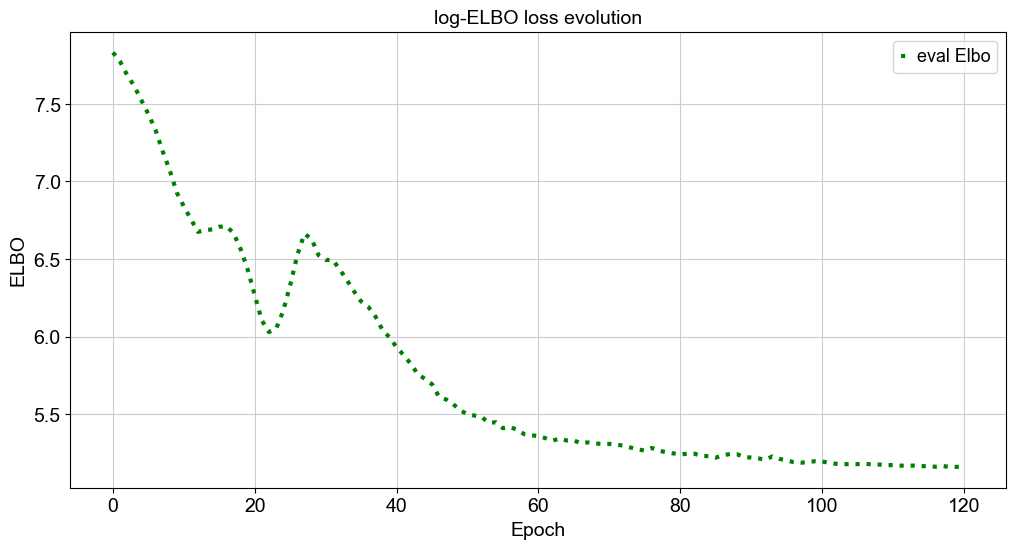

In [41]:
plot_elbo(trainer, 10)

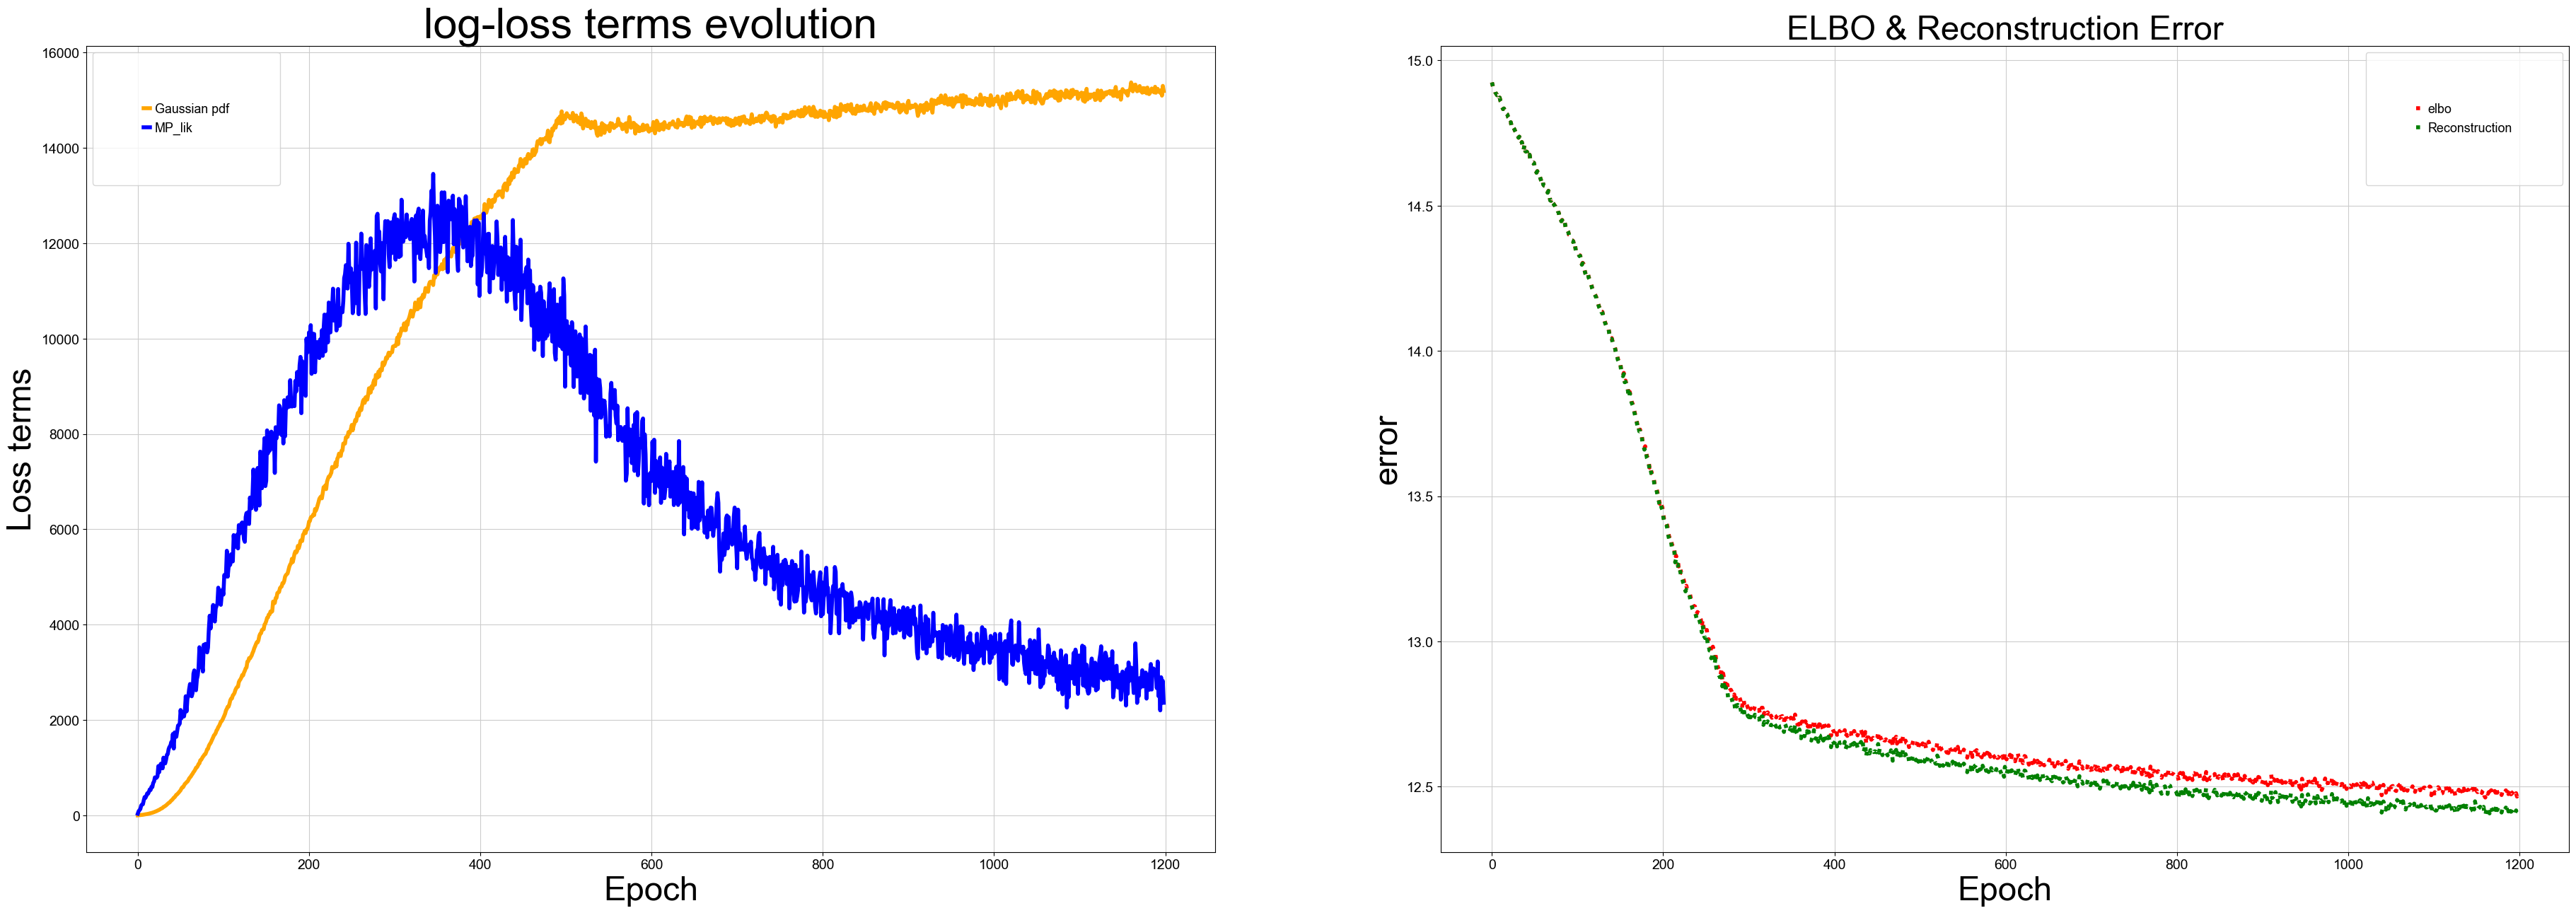

In [42]:
plot_losses(trainer=trainer)

In [44]:
full_posterior = trainer.create_posterior(trainer.model, cas_dataset, trainer.clades,
                                indices=np.arange(len(cas_dataset)))

cascvi_latent = full_posterior.get_latent()[0]
cascvi_latent.shape

(1200, 5)

//anaconda3/envs/berkeley/lib/python3.7/site-packages/matplotlib/collections.py:1039: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


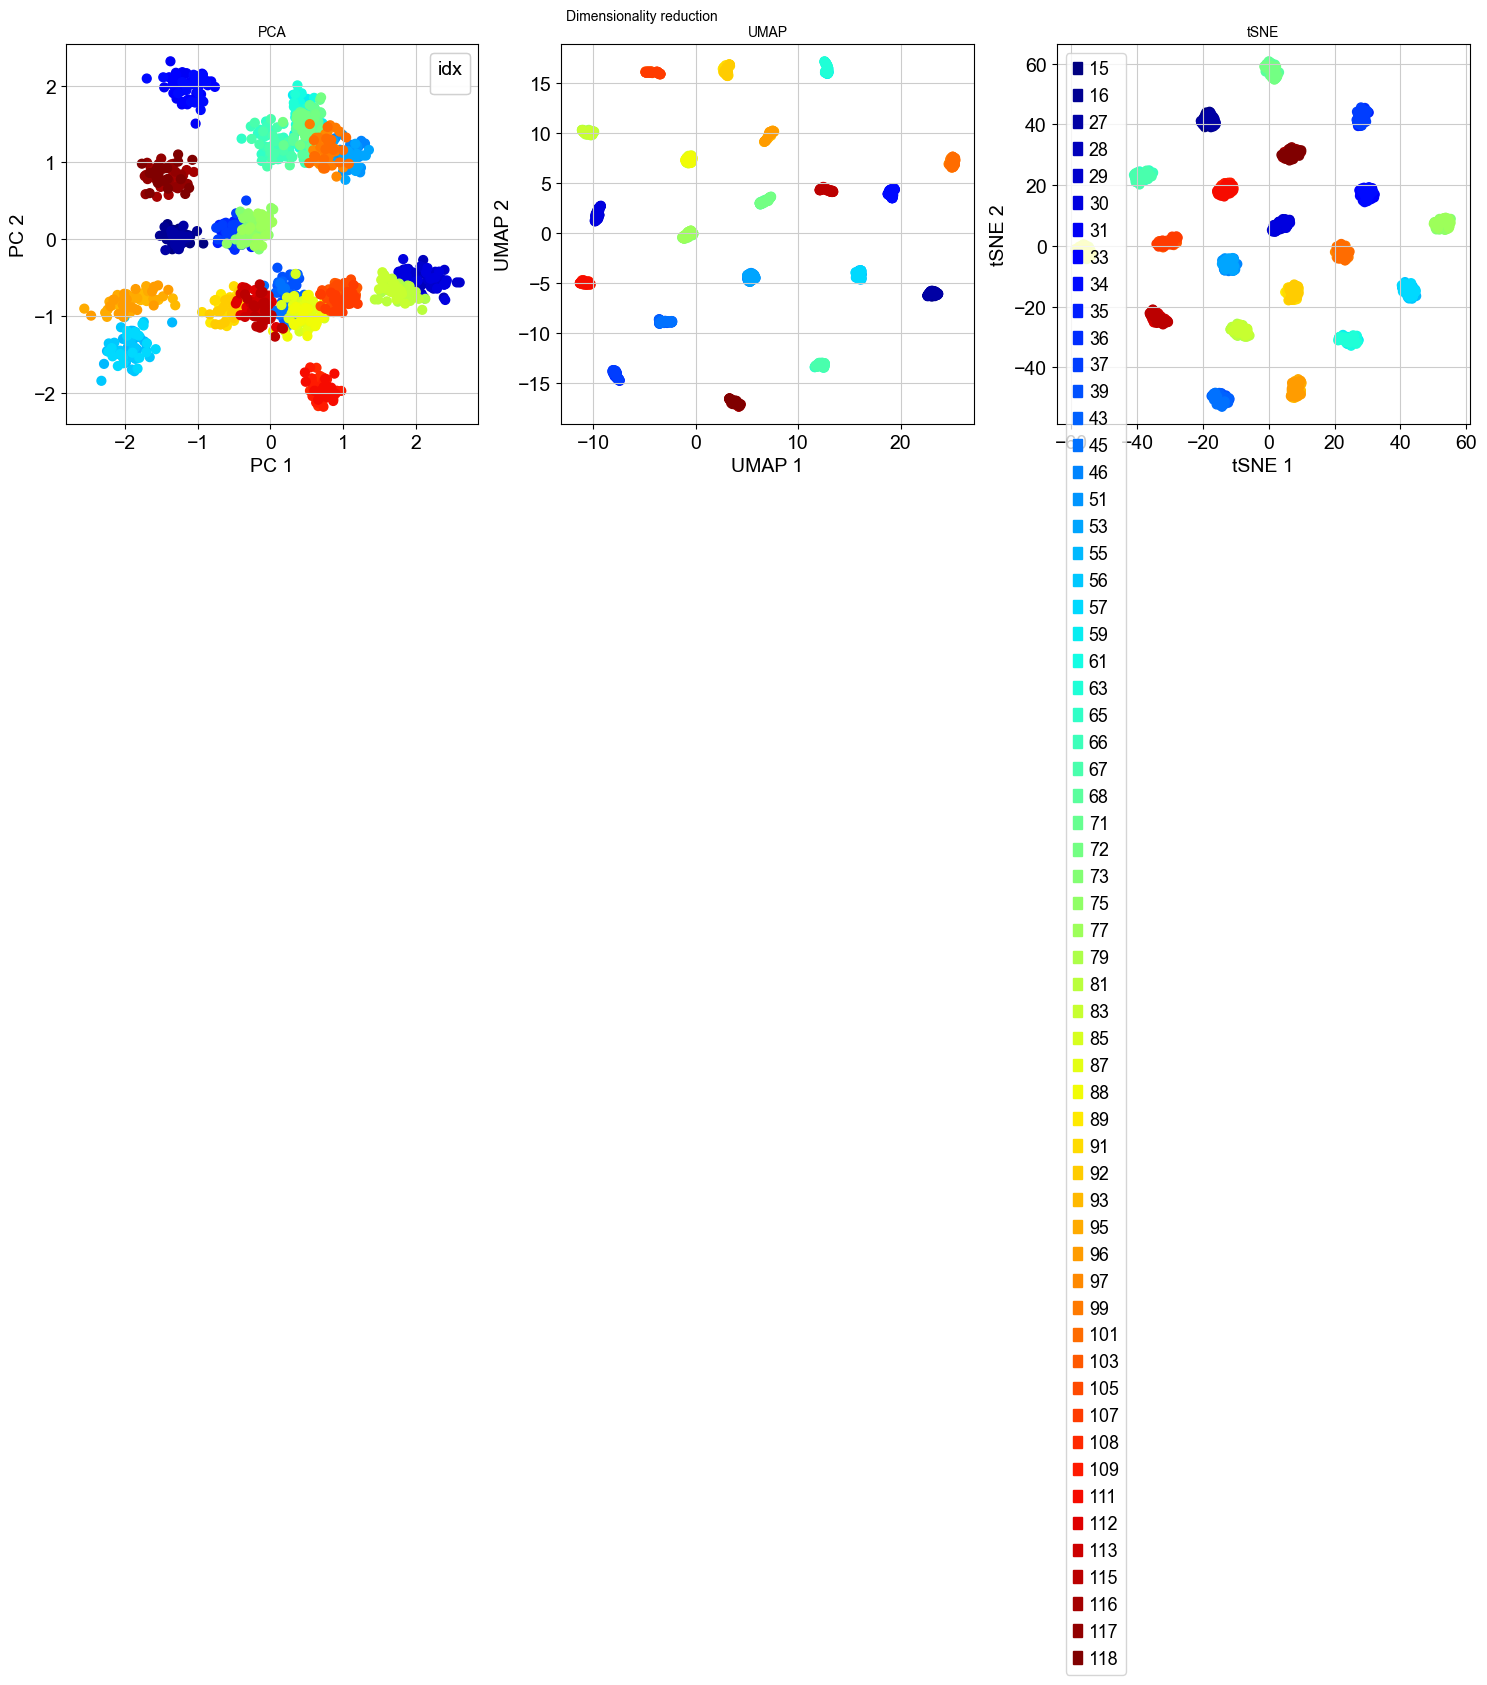

In [45]:
group = np.array([ [int(i)] * len(n_leaves_X) for i in leaves_idx]).flatten()
plot_embedding(X=cascvi_latent, 
                color_index=group,
              sizes=[40 for i in range(cascvi_latent.shape[0])])

***Posterior predictive imputation***

In [46]:
empirical_l = 240
empirical_var = {}

# CascVI imputations
imputed = {}
imputed_z = {}
for n in t.traverse('levelorder'):
    if not n.is_leaf():
        imputed[n.name], empirical_var[n.name], imputed_z[n.name] = full_posterior.imputation_internal(n.name,
                                                            give_mean=False,
                                                            library_size=empirical_l,
                                                            empirical_var=True
                                                            )
    else:
        imputed[n.name] = glm.X[n.index]
        
imputed_X = [x for x in imputed.values()]
imputed_X = np.array(imputed_X).reshape(-1, glm.X.shape[1])

Add imputed latent vectors to the latent space 

In [47]:
# No PP-averaging
N = 1

new_cascvi_latent = []
internal_group = []
sizes = []
idx = 0

for i, n in enumerate(augmented_t.traverse()):
    if n.is_leaf():
        new_cascvi_latent.append(cascvi_latent[idx])
        sizes.append(70)
        idx += 1
    else:
        new_cascvi_latent.append(imputed_z[n.name])
        internal_group.append([int(n.name)]*N)
        for i in range(N):
            sizes.append(300)
            
new_cascvi_latent = np.vstack(new_cascvi_latent)

In [48]:
new_group = list(group) + list(np.array(internal_group).flatten())
new_group.sort()

//anaconda3/envs/berkeley/lib/python3.7/site-packages/matplotlib/collections.py:1039: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


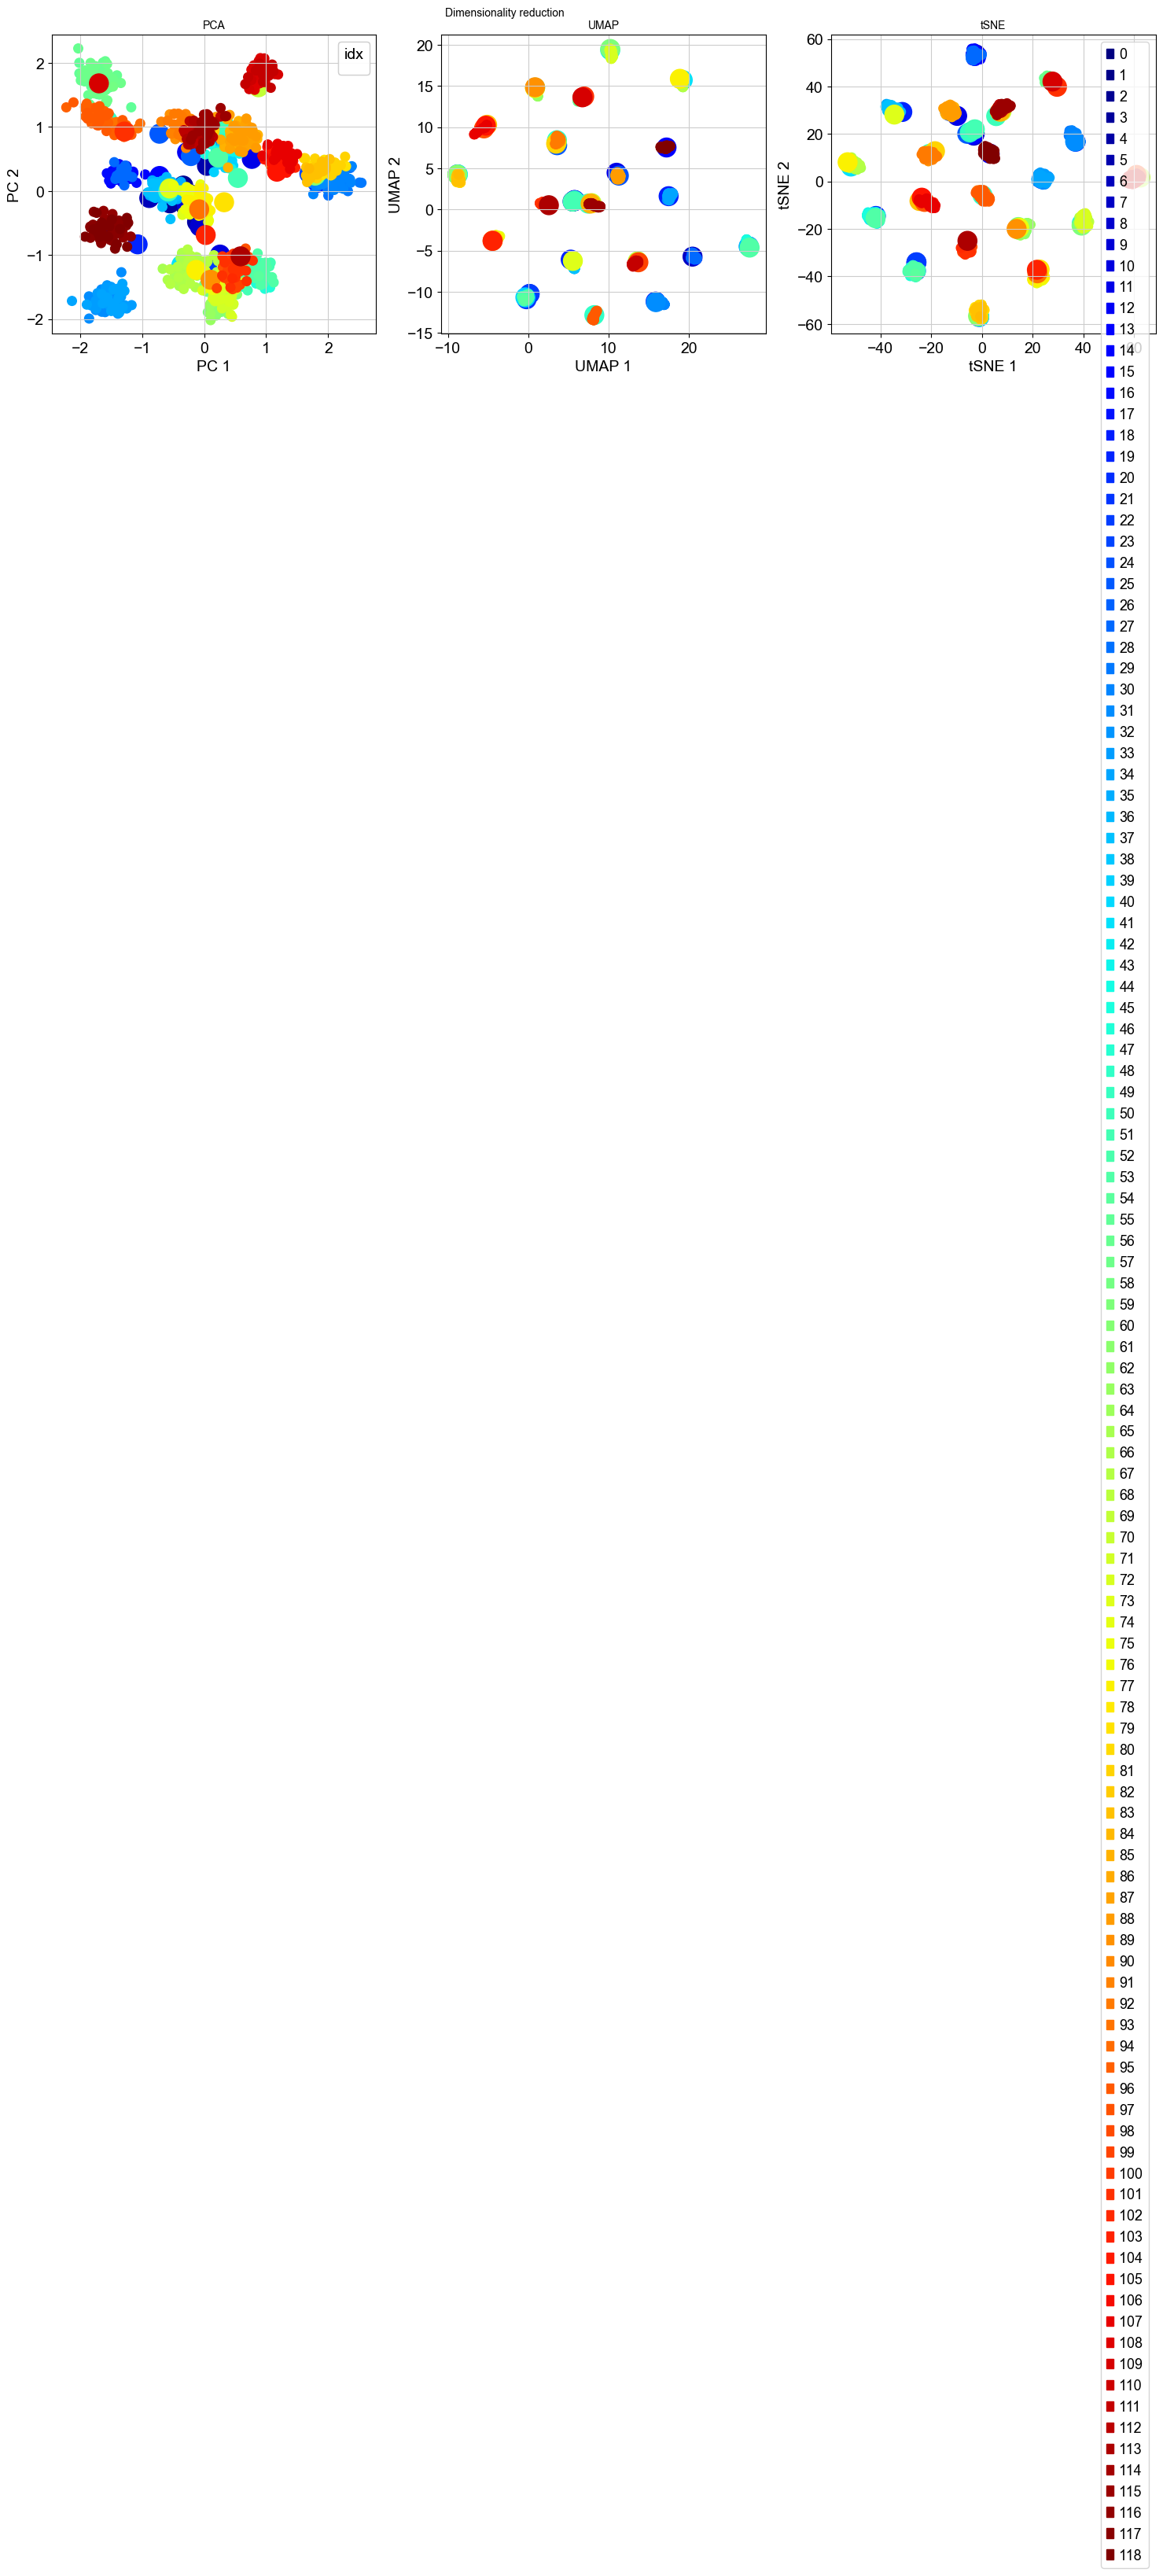

In [49]:
plot_embedding(X=new_cascvi_latent, 
                color_index=new_group,
               sizes=sizes
             )

***CascVI baselines***

In [51]:
# CascVI baseline 1
imputed_cascvi, imputed_cascvi_z = scvi_baseline(augmented_t, full_posterior, False, True, N)

# CascVI baseline 2
imputed_cascvi_2 = scvi_baseline_z(tree=augmented_t,
                                   model=vae,
                                   posterior=full_posterior,
                                   weighted=True,
                                   n_samples_z=100,
                                   library_size=10000     
                                  )

# CascVI baseline 3
imputed_cascvi_3 = cascvi_baseline_z(tree=augmented_t,
                                   model=vae_scvi,
                                   latent=imputed_z,
                                   library_size=10000     
                                  )


# 4. k-NN purity

In [52]:
from inference.posterior_utils import knn_purity
import copy

labels = copy.deepcopy(np.array(new_group))

In [53]:
n_neighbors = [10, 20, 30, 40, 50, 60, 100]

score_scvi = [knn_purity(new_scvi_latent, labels, n) for n in n_neighbors]
score_cascvi = [knn_purity(new_cascvi_latent, labels, n) for n in n_neighbors]

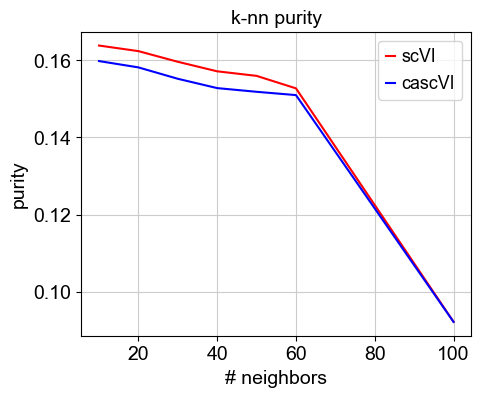

In [54]:
plt.plot(n_neighbors, score_scvi, color='red', label='scVI')
plt.plot(n_neighbors, score_cascvi, color='blue', label='cascVI')
plt.xlabel('# neighbors'), plt.ylabel("purity"), plt.title("k-nn purity")
plt.legend()

plt.show()

In [75]:
labels

array([  0,   1,   2, ..., 118, 118, 118])

# 5. Tree PLOTS

***Convert ete3 tree to a Networkx graph for visualizations***

In [ ]:
def tree_to_nx(tree, X, g, show_index):
    label_dict = {}
    graph = nx.DiGraph()
    for i, n in enumerate(tree.traverse()):
        if n.is_root():
            continue
        graph.add_node(n.name)
        if show_index:
            label_dict[n.name] = n.index
        else:
            label_dict[n.name] = str(int(X[i][g]))
        graph.add_edge(n.up.name, n.name)
    return graph, label_dict

***Plot for one gene***

In [ ]:
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import pdb
import random

def plot_one_gene(tree, X, g, node_sizes, var, size, show_index):
    graph, label_dict = tree_to_nx(tree, X, g, show_index)
    pos = nx.nx_pydot.graphviz_layout(graph, prog="dot")
    
    # variance
    node_sizes_gene = []
    if var == 'gene':
        L = [int(x) for x in node_sizes.keys()]
        L.sort()
        node_sizes_gene = [size*node_sizes[str(k)][g] for k in L]
        #node_sizes_gene = [size] + node_sizes_gene
        
        plt.figure(1, figsize=(6,6)) 
        nx.draw(graph, labels=label_dict, with_labels=True, pos=pos, node_size=node_sizes_gene,
                font_size=14, font_color='white')
    else:   
        plt.figure(1, figsize=(6,6)) 
        nx.draw(graph, labels=label_dict, with_labels=True, pos=pos, node_size=node_sizes,
                font_size=14, font_color='white')
    
    
    
    plt.show()

In [ ]:
print(">>> Groundtruth (Gene Expression) <<<")
#g_vis = random.sample(range(1, 100), 1)[0]
g_vis = 0
print("Gene n° {}".format(g_vis))
plot_one_gene(tree=t, 
              X=glm.X, 
              g=g_vis,
              node_sizes=[800 for i in range(glm.X.shape[0])],
              var='latent',
              size=1000,
              show_index=True
             )

In [ ]:
print(">>> Groundtruth (Gene Expression) <<<")
plot_one_gene(tree=t, 
              X=glm.X, 
              g=g_vis,
              node_sizes=[1500 for i in range(glm.X.shape[0])],
              var='latent',
              size=1000,
              show_index=False
             )

#### Average Baseline

In [56]:
weighted = True
imputed_avg = avg_weighted_baseline(t, True, glm.X)

#get internal nodes
avg_X = np.array([x for x in imputed_avg.values()]).reshape(-1, glm.X.shape[1])
internal_avg_X, _, _ = get_internal(avg_X, glm.mu, t)
internal_avg_X.shape

(59, 100)

#### Average Baseline (Augmented tree)

In [57]:
weighted = True
imputed_avg = avg_weighted_baseline(augmented_t, True, glm.X)

#get internal nodes
avg_X = np.array([x for x in imputed_avg.values()]).reshape(-1, glm.X.shape[1])
internal_avg_X, _, _ = get_internal(avg_X, glm.mu, t)
internal_avg_X.shape

IndexError: index 145 is out of bounds for axis 0 with size 119

In [62]:
internal_avg_X.shape

(59, 100)

In [ ]:
print(">>> Average Baseline <<<")
plot_one_gene(tree=t, 
              X=avg_X, 
              g=g_vis,
              node_sizes=[2000 for i in range(glm.X.shape[0])],
              var='latent',
              size=1000,
              show_index=False
             )

# 6. Variance analysis

## 6.1 Variance in Latent Space

In [ ]:
# Get empirical variance of the encoder
qz_v_norm_augmented = full_posterior.empirical_qz_v(
                                    n_samples=1000,
                                    norm=True)

In [ ]:
qz_v_norm = [np.mean(qz_v_norm_augmented[i: (i+1)*N]) for i in range(len(leaves_idx))]

In [ ]:
var_dict = {}
node_sizes = []

for i, n in enumerate(t.traverse('levelorder')):
    if not n.is_leaf():
        # if n is an internal node, we get the variance from the prior
        z = full_posterior.get_latent(give_mean=False)[0]
        _, v_nu = vae.posterior_predictive_density(query_node=n.name, 
                                                  evidence=z) 
        
        var_dict[n.name] = str(np.around(a=v_nu,
                             decimals=4)
                              )
        node_sizes.append(np.around(a=v_nu,
                             decimals=4)
                         )
    else:
        idx = leaves_idx.index(n.index)
        # if n is a leaf, we get the variance from the encoder
        
        # variational distribution variance
        
        # Empirical variance
        var_dict[n.name] = str(np.around(a=qz_v_norm[idx],
                                 decimals=4)
                             )
        node_sizes.append(np.around(a=qz_v_norm[idx],
                                 decimals=4) 
                         )

***CascVI***

In [ ]:
plot_one_gene(tree=t, 
              X=imputed_X, 
              g=g_vis, 
              node_sizes=[int(n*100000) for n in node_sizes], #+[1000]
              var='latent',
              size=1000,
              show_index=False
             )

print("CascVI: Imputations + Variance analysis")

***scVI***

In [ ]:
qz_v_scvi = np.var([scvi_posterior.get_latent(give_mean=False)[0] for i in range(1000)], axis=0, dtype=np.float64)
norm_qz_v_scvi = [np.linalg.norm(v) for v in qz_v_scvi]
norm_qz_v_scvi = [np.mean(norm_qz_v_scvi[i: (i+1)*N]) for i in range(len(leaves_idx))]

In [ ]:
node_sizes = [0]*(glm.X.shape[0])
idx = 0
for i, n in enumerate(t.traverse()):
    if n.is_leaf():
        node_sizes[i] = norm_qz_v_scvi[idx]
        idx += 1

In [ ]:
plot_one_gene(tree=t, 
              X=imputed_scvi_X, 
              g=g_vis, 
              node_sizes=[int(n*100000) for n in node_sizes], #+[1000]
              var='latent',
              size=1000,
              show_index=False
             )
print("scVI: Imputations + Variance analysis")

***scVI VS CascVI (variance)***

In [ ]:
norm_qz_v_scvi, var_dict

## 6.2 Variance in gene space

***CascVI***

Create dictionary with empirical variance

In [ ]:
# Decodings
leaves_reconstructed = np.mean(full_posterior.generate_leaves(n_samples=1000)[0], axis=2)
#leaves_reconstructed = full_posterior.generate_leaves(n_samples=1000)[0]

# variance of leaves in the original tree
#leaves_var = [np.var(leaves_reconstructed[i: (i+1)*N], axis=0) for i in range(len(leaves_idx))]
leaves_var = np.var(full_posterior.generate_leaves(n_samples=1000)[0], axis=2)

#i = 0
#for n in t.traverse('levelorder'):
#    if str(n.index) not in empirical_var:
#        print(n.index)
#        empirical_var[str(n.index)] = leaves_var[i]
#       i += 1

In [ ]:
#g_vis = 18

#plot_one_gene(tree=t, 
#              X=imputed_X, 
#              g=g_vis, 
#              node_sizes=empirical_var,
#              var='gene',
#              size=1000,
#              show_index=False
#             )

#print("Imputations + Variance analysis in gene space")

***scVI***

In [ ]:
# scVI decodings
scvi_leaves = np.mean(scvi_posterior.generate(n_samples=1000)[0], axis=2)

# variance of leaves in the original tree
#scvi_leaves_var = [np.var(scvi_leaves[i: (i+1)*N], axis=0) for i in range(len(leaves_idx))]
scvi_leaves_var = np.var(scvi_posterior.generate(n_samples=1000)[0], axis=2)

In [ ]:
g_vis = 6
for i in range(240):
    print(leaves_var[i][g_vis])
    print(scvi_leaves_var[i][g_vis])
    print("")

In [ ]:
leaves_var[leaves_var > 1].shape[0] / leaves_var.flatten().shape[0]

In [ ]:
scvi_leaves_var[scvi_leaves_var > 5].shape[0] / scvi_leaves_var.flatten().shape[0]

In [ ]:
node_sizes = [0]*(glm.X.shape[0])
idx = 0
for i, n in enumerate(t.traverse()):
    if n.is_leaf():
        node_sizes[i] = scvi_leaves_var[idx][g_vis]
        idx += 1

In [ ]:
plot_one_gene(tree=t, 
              X=imputed_scvi_X, 
              g=g_vis,
              node_sizes=[n*1000 for n in node_sizes],
              var='latent',
              size=1000,
              show_index=False
             )

print("Imputations + Variance analysis in gene space")

# 7. Summary stats

***Empirical Variance scVI vs CascVI***

In [ ]:
idx = random.sample(range(1, len(leaves_idx)), 1)[0]
print("Leaf number {}".format(idx))
start = idx*N
end = (idx+1)*N
plot_scatter_samples(leaves_var[start:end], scvi_leaves_var[start: end], color='blue')

***Mean scVI vs CascVI***

In [ ]:
imputed_mean = full_posterior.sequential().imputation_mean(n_samples=1)
scvi_imputed_mean = scvi_posterior.sequential().imputation(n_samples=1)

In [ ]:
print("Leaf number {}".format(idx))
plot_scatter_samples(imputed_mean[start: end], scvi_imputed_mean[start: end], color='green')

In [ ]:
print("Leaf number {}".format(idx))
plot_scatter_samples(leaves_reconstructed[start:end], scvi_leaves[start:end], color='red')


***Library Size***

In [ ]:
plt.scatter(scvi_l, cascvi_l)

In [ ]:
cascvi_l / scvi_l 

***Gene expression frequency scVI vs CascVI***

In [ ]:
len(vae.expected_ge)

In [ ]:
vae.expected_ge[0].shape

In [ ]:
plot_histograms(leaves_reconstructed, 'cascvi')

In [ ]:
plot_histograms(scvi_leaves, 'scvi')

# 8. Imputation evaluation

In [67]:
#scVI
internal_scvi_X = np.array([x for x in imputed_scvi.values()]).reshape(-1, glm.X.shape[1])
internal_scvi_X_2 = np.array([x for x in imputed_scvi_2.values()]).reshape(-1, glm.X.shape[1])

#CascVI
internal_imputed_X, _, _ = get_internal(imputed_X, glm.mu, t)
internal_cascvi_X = np.array([x for x in imputed_cascvi.values()]).reshape(-1, glm.X.shape[1])
internal_cascvi_X_2 = np.array([x for x in imputed_cascvi_2.values()]).reshape(-1, glm.X.shape[1])
internal_cascvi_X_3 = np.array([x for x in imputed_cascvi_3.values()]).reshape(-1, glm.X.shape[1])

internal_X.shape, internal_avg_X.shape, internal_imputed_X.shape, internal_scvi_X.shape, internal_scvi_X_2.shape, internal_cascvi_X.shape, internal_cascvi_X_2.shape, internal_cascvi_X_3.shape

((59, 100),
 (59, 100),
 (59, 100),
 (59, 100),
 (59, 100),
 (59, 100),
 (59, 100),
 (59, 100))

In [68]:
from sklearn.preprocessing import normalize

norm_internal_X = sc.pp.normalize_total(AnnData(internal_X), target_sum=1e4, inplace=False)['X']

#scVI
norm_scvi_X = sc.pp.normalize_total(AnnData(internal_scvi_X), target_sum=1e4, inplace=False)['X']
norm_scvi_X_2 = sc.pp.normalize_total(AnnData(internal_scvi_X_2), target_sum=1e4, inplace=False)['X']

#Avg
norm_avg_X = sc.pp.normalize_total(AnnData(internal_avg_X), target_sum=1e4, inplace=False)['X']

#CascVI
norm_imputed_X = sc.pp.normalize_total(AnnData(internal_imputed_X), target_sum=1e4, inplace=False)['X']
norm_cascvi_X = sc.pp.normalize_total(AnnData(internal_cascvi_X), target_sum=1e4, inplace=False)['X']
norm_cascvi_X_2 = sc.pp.normalize_total(AnnData(internal_cascvi_X_2), target_sum=1e4, inplace=False)['X']
norm_cascvi_X_3 = sc.pp.normalize_total(AnnData(internal_cascvi_X_3), target_sum=1e4, inplace=False)['X']

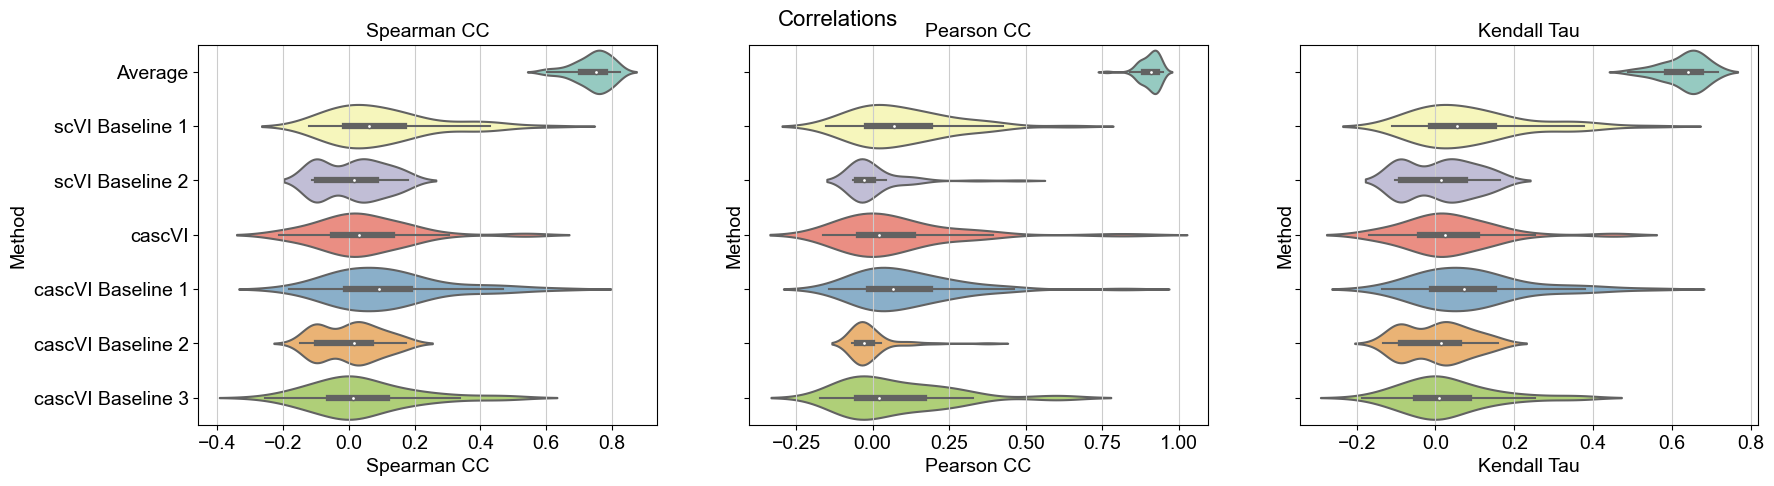

In [69]:
data = [internal_X.T, internal_imputed_X.T, internal_avg_X.T ,internal_scvi_X.T,
        internal_scvi_X_2.T, internal_cascvi_X.T, internal_cascvi_X_2.T, internal_cascvi_X_3.T]
df1 = correlations(data, 'None', True)
df1.head(5)
plt.show()

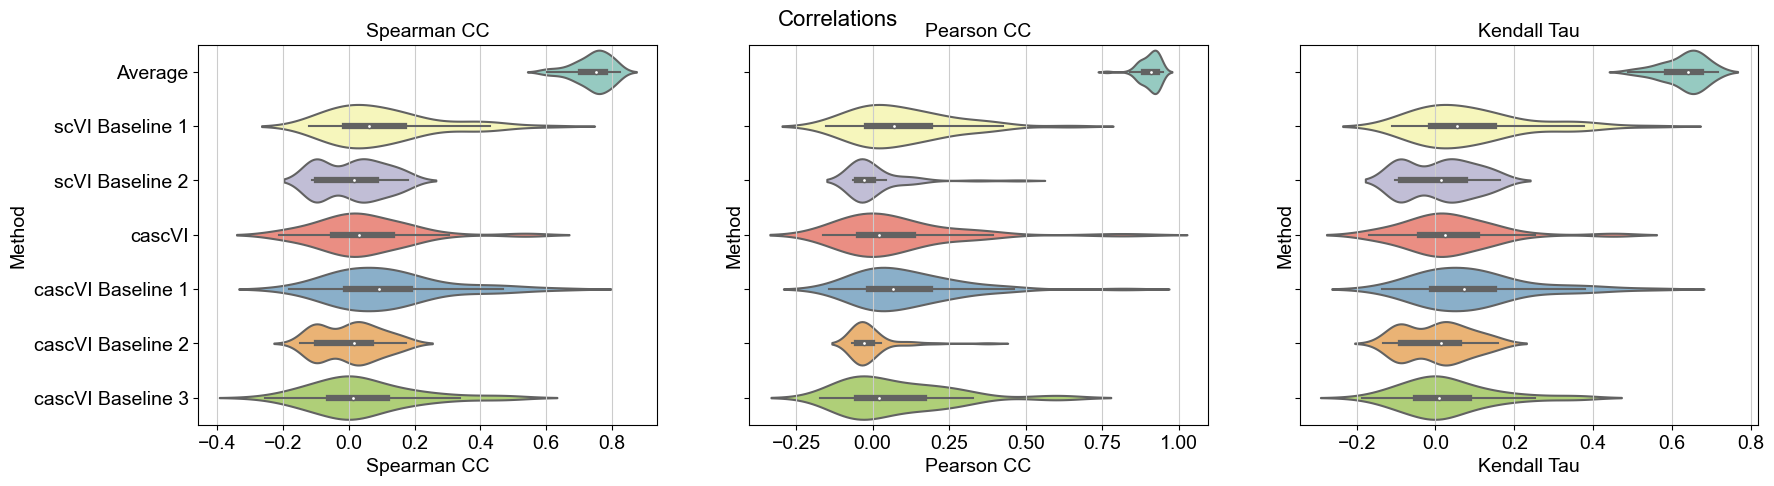

In [70]:
data = [norm_internal_X.T, norm_imputed_X.T, norm_avg_X.T ,norm_scvi_X.T,
        norm_scvi_X_2.T, norm_cascvi_X.T, norm_cascvi_X_2.T, norm_cascvi_X_3.T]
df2 = correlations(data, 'None', True)
df2.head(5)
plt.show()

//anaconda3/envs/berkeley/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
//anaconda3/envs/berkeley/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


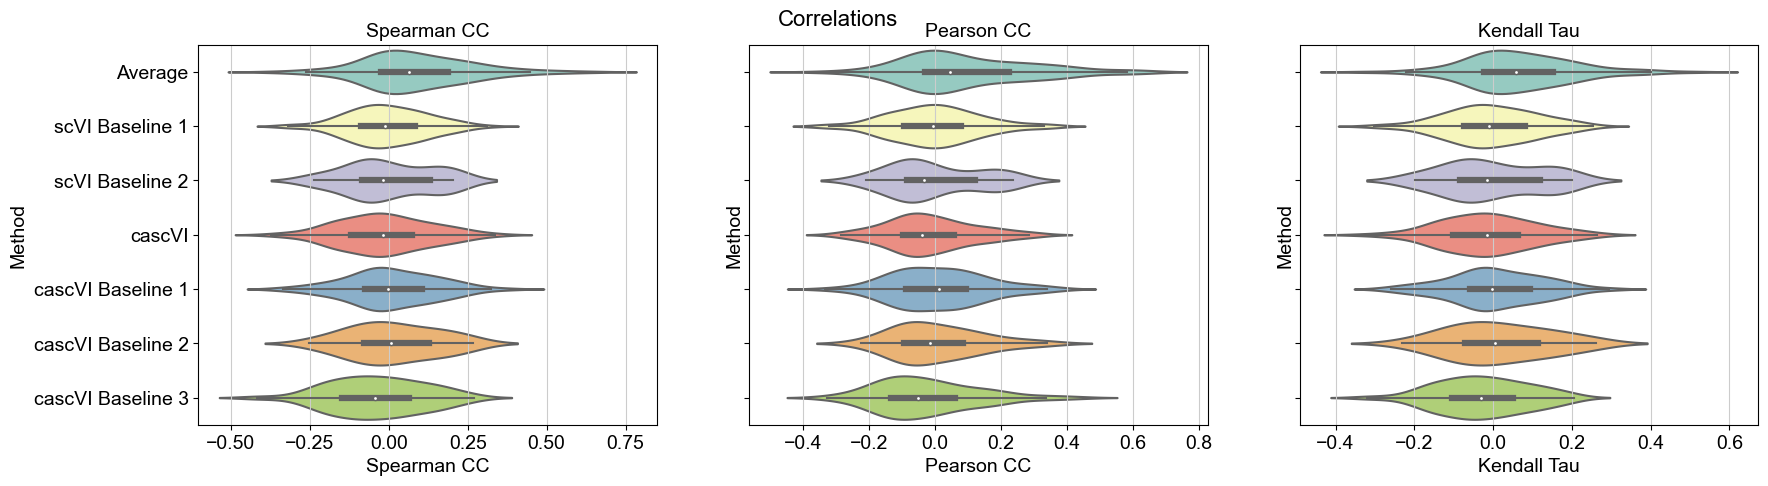

In [71]:
data = [internal_X, internal_imputed_X, internal_avg_X ,internal_scvi_X,
        internal_scvi_X_2, internal_cascvi_X, internal_cascvi_X_2, norm_cascvi_X_3]
df3 = correlations(data, 'None', True)
df3.head(5)
plt.show()

//anaconda3/envs/berkeley/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
//anaconda3/envs/berkeley/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


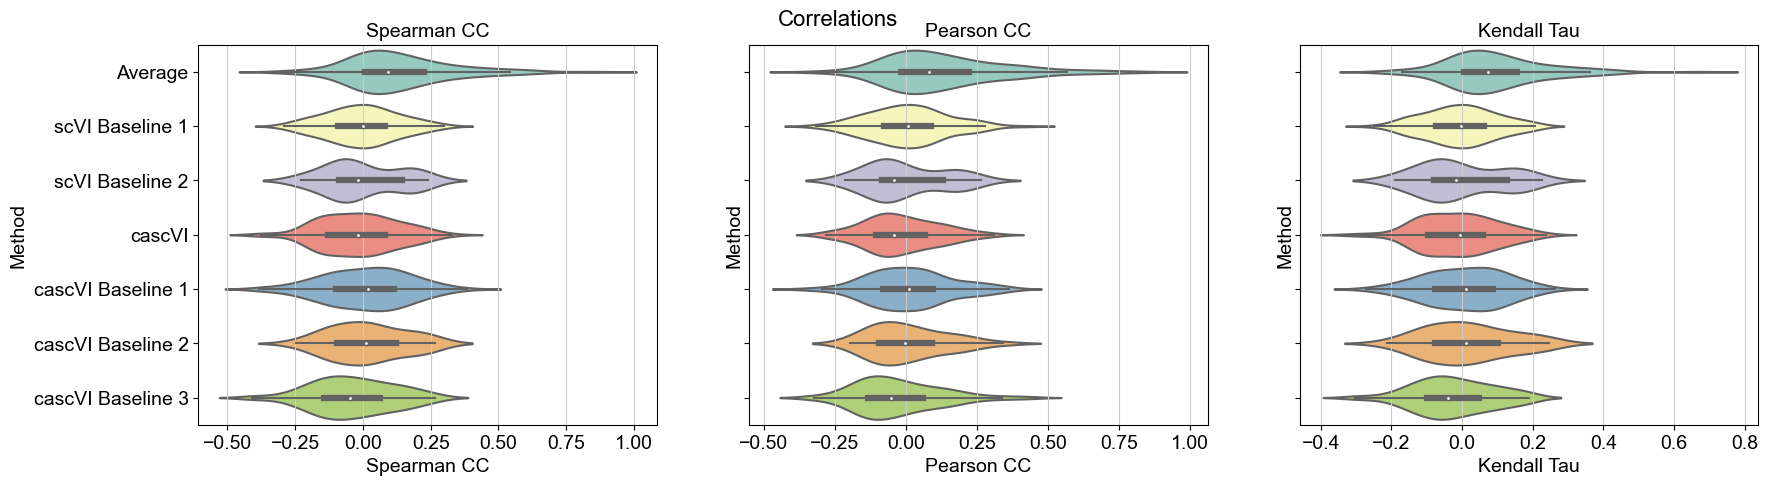

In [72]:
data = [norm_internal_X, norm_imputed_X, norm_avg_X ,
        norm_scvi_X, norm_scvi_X_2, norm_cascvi_X, internal_cascvi_X_2,
       internal_cascvi_X_3]

df4 = correlations(data, 'None', True)
df4.head(5)
plt.show()

//anaconda3/envs/berkeley/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
//anaconda3/envs/berkeley/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


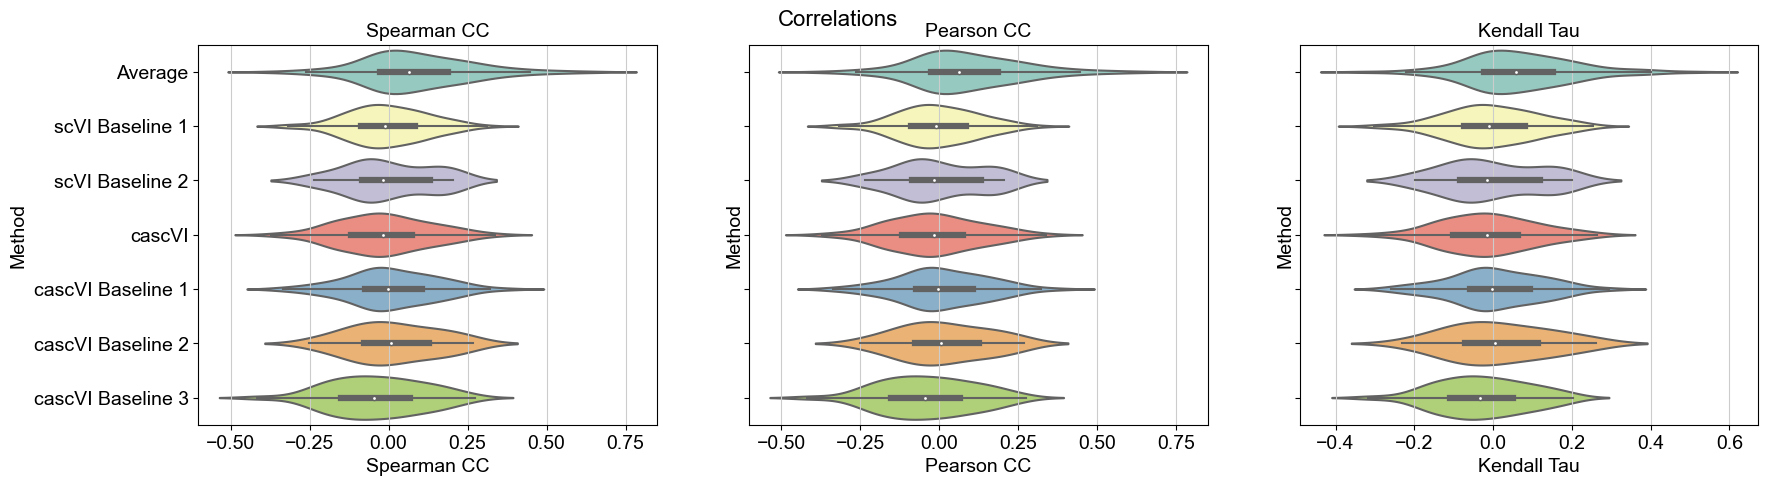

In [73]:
data = [internal_X, internal_imputed_X, internal_avg_X ,
        internal_scvi_X, internal_scvi_X_2, internal_cascvi_X, internal_cascvi_X_2,
       internal_cascvi_X_3
       ]

df5 = correlations(data, 'rank', True)
df5.head(5)
plt.show()

//anaconda3/envs/berkeley/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
//anaconda3/envs/berkeley/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


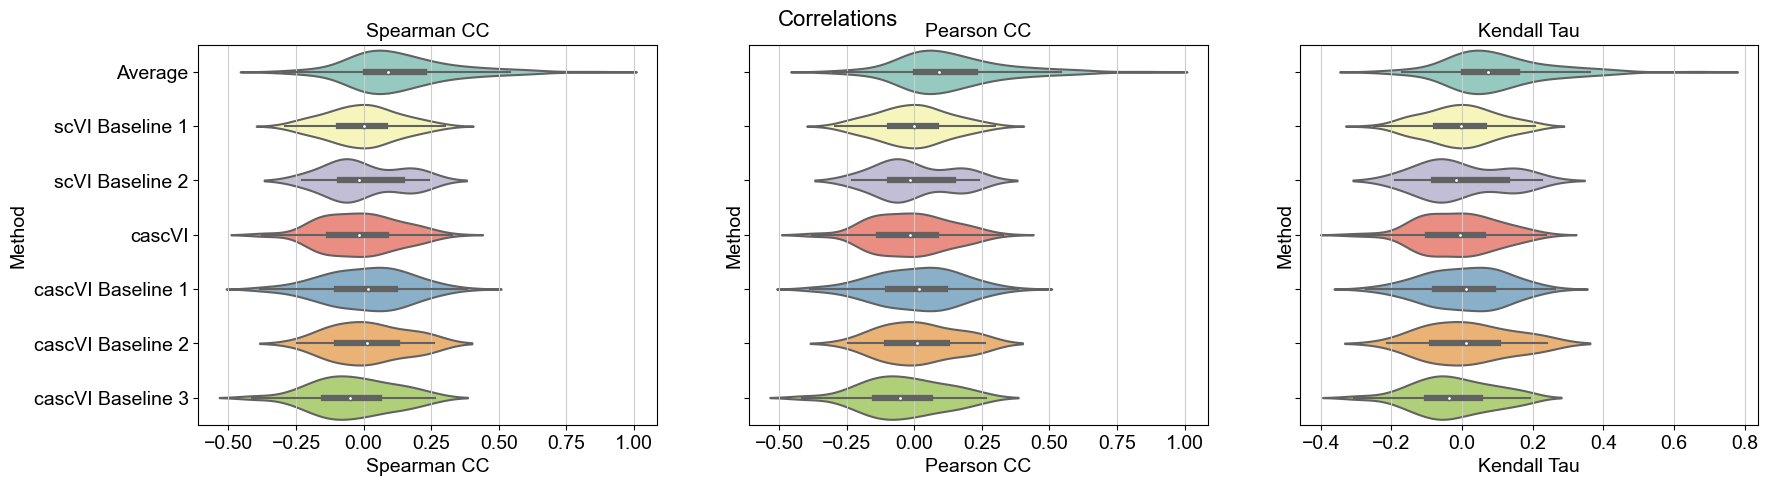

In [74]:
data = [norm_internal_X, norm_imputed_X, norm_avg_X ,
        norm_scvi_X, norm_scvi_X_2, norm_cascvi_X, norm_cascvi_X_2, norm_cascvi_X_3]
df = correlations(data, 'rank', True)
df.head(5)
plt.show()